In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from lmfit.models import LorentzianModel
from lmfit.models import VoigtModel
from lmfit import Model

import os

In [2]:
def gaussian(x, mean, amp, sigma):
    return amp * np.exp( -0.5 * ((x - mean) / sigma) ** 2) / (2.355 * sigma)

def res_fit(x, a, b, c):
    return (a*a/x + b*b)**0.5/100

def plot_fit(x, ax=None):
    ax = ax or plt.gca()
    bin_heights, bin_borders, _ = plt.hist(x, bins=30, range=(-0.15, 0.15))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[np.mean(x), 1, 2*np.std(x)])
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 90000)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
    print(np.mean(x), np.std(x))
    print(popt)
    return popt[2]
      
def bin_fit(x):
    #     bin_heights, bin_borders = np.histogram(x, bins=100)
    plt.clf()
    bin_heights, bin_borders, _ = plt.hist(x, bins=30, range=(-2*np.std(x), 2*np.std(x)))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    #     p0 =([-np.inf,0,-np.inf],[np.inf,2,np.inf])
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[np.mean(x), 1, 2*np.std(x)])
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 90000)
    return popt[2]

def Lorentzian_fit(x):
    plt.clf()
    bin_heights, bin_borders, _ = plt.hist(x, bins=100, range=(-3*np.std(x), 3*np.std(x)))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    mod = LorentzianModel()
    pars = mod.guess(bin_heights, x = bin_centers)
    x = x[np.abs(x) < np.std(x) * 2]
    out = mod.fit(bin_heights, pars, x = bin_centers)
    return np.std(x) # out.params['sigma'].value, out.params['sigma'].stderr

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import uproot
from collections import deque

In [4]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [5]:
def res_fit(x, a, b):
    return (a / np.sqrt(x) + b)

In [6]:
def e_res(truth_train, pred_train, truth_test, pred_test, conf='baseline', bins=8):
    
    pred_train_bins = []
    truth_train_bins = []
    arange = np.arange(len(truth_train))
    for idx in np.array_split(np.arange(len(truth_train), dtype=np.int64), bins):
    # for idx in np.array_split(arange, np.logspace(5, np.log(len(truth_train)), bins, base=np.e).astype(int)):
        pred_train_bins.append(pred_train[idx])
        truth_train_bins.append(truth_train[idx])

    pred_test_bins = []
    truth_test_bins = []
    arange = np.arange(len(truth_test))
    for idx in np.array_split(np.arange(len(truth_test), dtype=np.int64), bins):
    # for idx in np.array_split(arange, np.logspace(5, np.log(len(truth_train)), bins, base=np.e).astype(int)):
        pred_test_bins.append(pred_test[idx])
        truth_test_bins.append(truth_test[idx])
    
    ex_train = [np.mean(truth_train_bins[i]) for i in range(bins) if len(truth_train_bins[i])]
    ey_train = [Lorentzian_fit(pred_train_bins[i]/truth_train_bins[i] - 1, i) for i in range(bins) if len(truth_train_bins[i])]

    ex_test = [np.mean(truth_test_bins[i]) for i in range(bins)]
    ey_test = [Lorentzian_fit(pred_test_bins[i]/truth_test_bins[i] - 1, i) for i in range(bins) if len(truth_test_bins[i]) if len(truth_train_bins[i])]
                                                                                                      

    fig, ax = plt.subplots(1, bins, figsize=(4*bins, 4), constrained_layout=True, dpi=200)
    bin_borders_err_x = []
    bin_borders_err_y = []
    
    std_length = TheScale
    for i in range(bins):
        if len(pred_test_bins[i]) == 0:
            continue
        # print(len(truth_test_bins[i]))
        x = pred_test_bins[i]/truth_test_bins[i] - 1
        mean = np.mean(x)
        
        bin_heights, bin_borders, _ = ax[i].hist(x, bins=TheBins, range=(mean-std_length*np.std(x), mean + std_length*np.std(x)))
        bin_heights_err, bin_borders_err = np.histogram(x, bins=TheBins, range=(mean-std_length*np.std(x), mean + std_length*np.std(x)), density=True)

        bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        bin_borders_err_x.append((np.mean(truth_test_bins[i]) - truth_test_bins[i][0], 
                                truth_test_bins[i][-1] - np.mean(truth_test_bins[i])))
        ax[i].set_title(f"Bin {str(i + 1)}")
        mod = BinNumMap.get(i, TheModel)()
        # mod = BinNumMap[i]() # TheModel()
        pars = mod.guess(bin_heights, x = bin_centers)
        out = mod.fit(bin_heights, pars, x = bin_centers, weights=bin_heights_err)
        bin_borders_err_y.append(out.params['sigma'].stderr)
        ax[i].plot(bin_centers, out.best_fit, 'r-')
    plt.show()
    
    x = ex_test
    y = np.array(ey_test)
    xerr = np.linspace(1, 10, len(x))
    yerr = np.linspace(0.01, 0.02, len(x))

    xnew = np.linspace(0.1, 20, 1000)
    
    pmodel = Model(res_fit)
    params = pmodel.make_params(a=0.14, b=0.1) # baseline
    result = pmodel.fit(y, params, x=x, calc_covar=True)
    
    ynew = result.eval(x=xnew)
    bin_borders_err_y, bin_borders_err_x
    
    plot_data = {
        'x': x,
        'y': y,
        'xerr': xerr,
        'yerr': yerr,
        'xnew': xnew,
        'ynew': ynew,
        'bin_borders_err_y': bin_borders_err_y,
        'bin_borders_err_x': bin_borders_err_x,
        'ynew': ynew,
        'result': result
    }
    return plot_data


In [7]:
from lmfit.models import SkewedVoigtModel, SkewedGaussianModel, GaussianModel, ExponentialGaussianModel
from lmfit.models import StudentsTModel, LognormalModel


def Lorentzian_fit(x, bin_num):
    # plt.clf()
    # print(len(x))
    scale = TheScale
    mean = np.mean(x)
    bin_heights, bin_borders, _ = plt.hist(x, bins=TheBins, range=(mean - scale * np.std(x), mean + scale * np.std(x)))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    
    mod = BinNumMap.get(bin_num, GaussianModel)() # TheModel()
    pars = mod.guess(bin_heights, x = bin_centers)
    # x = x[np.abs(x) < np.std(x) * 2]
    out = mod.fit(bin_heights, pars, x = bin_centers)
    return out.params['sigma'].value # , out.params['sigma'].stderr

In [8]:
import statsmodels.api as sm
def load_data(prefix_energy='new_data/new_data/E_pure_em_test_{}.npy', prefix_tracks='new_data/new_data/e_pure_em_test_{}.npy'):
    E_true = np.concatenate([
        np.load(prefix_energy.format(i)) for i in [1, 2, 3]
    ])
    n_tracks = np.concatenate([
        np.load(prefix_tracks.format(i)) for i in [1, 2, 3]
    ])

    rlm_model = sm.RLM(E_true, sm.add_constant(n_tracks))
    rlm_results = rlm_model.fit()
    E_pred = rlm_results.predict(sm.add_constant(n_tracks))
    idx_sorted = np.argsort(E_true)
    E_true = E_true[idx_sorted]
    E_pred = E_pred[idx_sorted]
    return E_true, E_pred

In [9]:

TheModel = GaussianModel # GaussianModel
TheScale = 4
TheBins = 50
NumBaskets = 11
BinNumMap = {i: GaussianModel for i in range(100)}

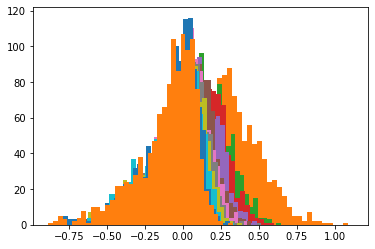

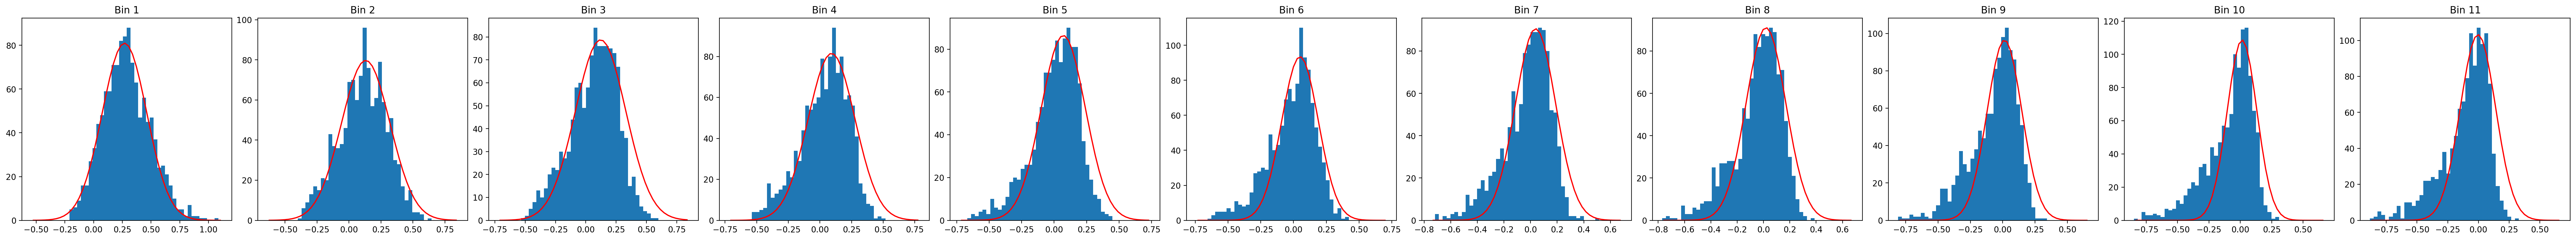

In [10]:
truth_train, pred_train = load_data(prefix_energy='new_data/new_data/E_pure_em_test_{}.npy', prefix_tracks='new_data/new_data/e_pure_em_test_{}.npy')
truth_test, pred_test = truth_train, pred_train
fit_data_pure_em = e_res(truth_train=truth_train, pred_train=pred_train, pred_test=pred_test, truth_test=truth_test, bins=NumBaskets)

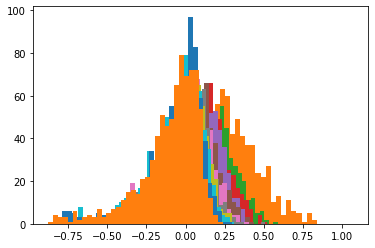

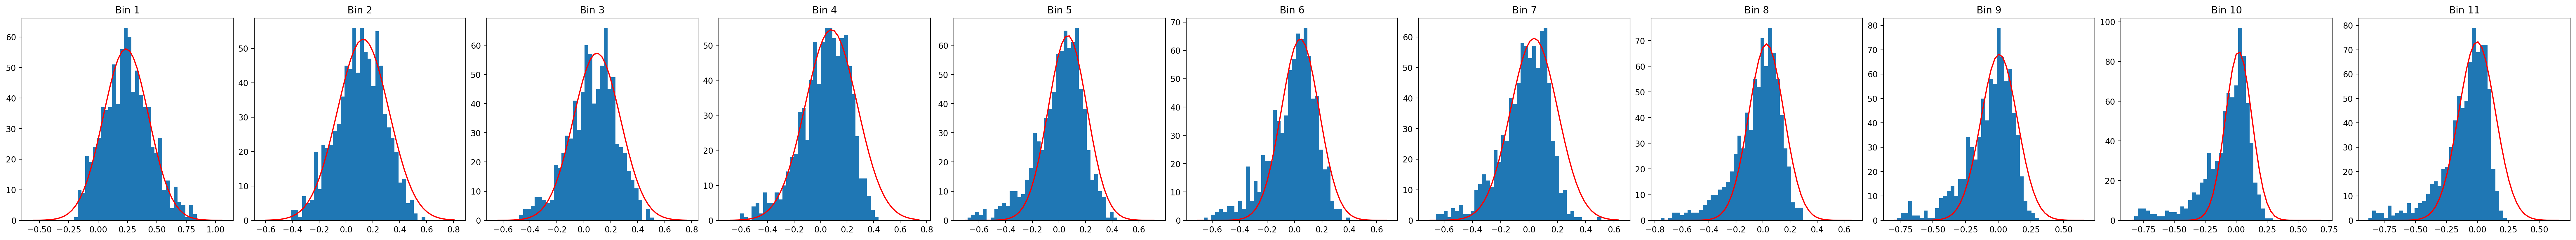

In [11]:
truth_train, pred_train = load_data(prefix_energy='new_data/new_data/E_eq_mix_test_{}.npy', prefix_tracks='new_data/new_data/e_eq_mix_test_{}.npy')
truth_test, pred_test = truth_train, pred_train
fit_data_eq_mix = e_res(truth_train=truth_train, pred_train=pred_train, pred_test=pred_test, truth_test=truth_test, bins=NumBaskets)

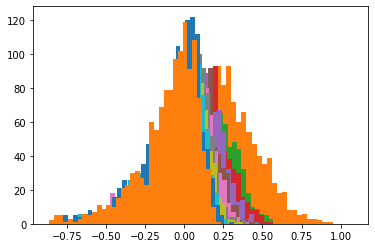

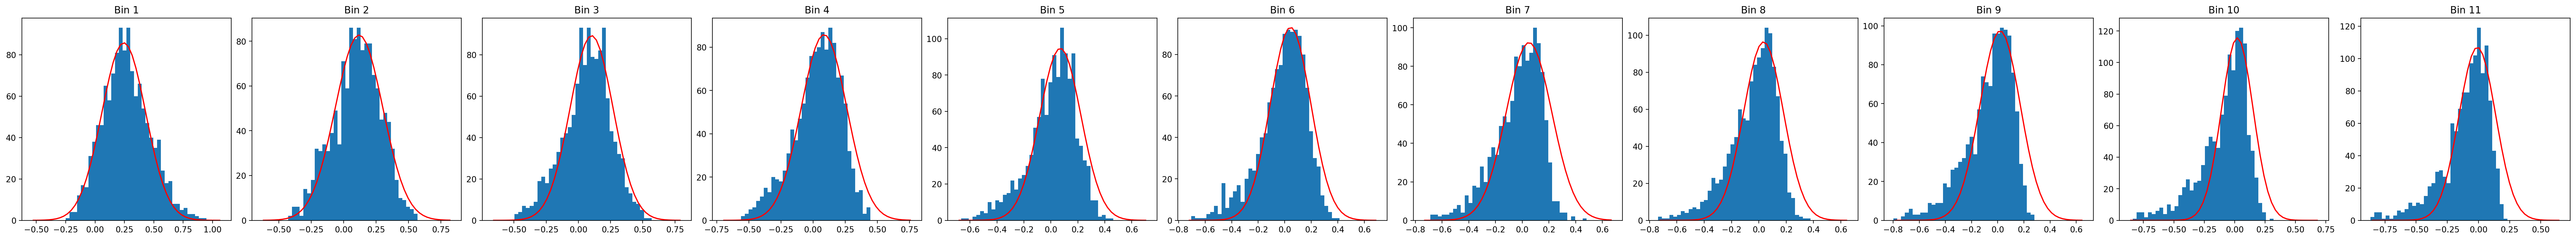

In [12]:
truth_train, pred_train = load_data(prefix_energy='new_data/new_data/E_test_{}.npy', prefix_tracks='new_data/new_data/e_test_{}.npy')
truth_test, pred_test = truth_train, pred_train
fit_data_em_mix = e_res(truth_train=truth_train, pred_train=pred_train, pred_test=pred_test, truth_test=truth_test, bins=NumBaskets)

In [13]:
def plot(fit_data, label, color='r'):
    ax.scatter(fit_data['x'], fit_data['y'], color=color, alpha=0.5)
    result = fit_data['result']
    
    if (~pd.isnull(fit_data['bin_borders_err_x'])).all():
        ax.errorbar(fit_data['x'], fit_data['y'], xerr=np.array(fit_data['bin_borders_err_x']).T, fmt='none', ecolor=color, alpha=0.5)
    
    if (~pd.isnull(fit_data['bin_borders_err_y'])).all():
        ax.errorbar(fit_data['x'], fit_data['y'], yerr=np.array(fit_data['bin_borders_err_y']), fmt='none', ecolor=color, alpha=0.5)

    if result.params['a'].stderr:
        a = "({:.3f}".format(result.params['a'].value) + r" ± " + "{:.3f})".format(result.params['a'].stderr)
    elif result.params['a'].value:
        a = "{:.3f}".format(result.params['a'].value)
    else:
        a = 0
        
    if result.params['b'].stderr:
        b = "({:.3f}".format(result.params['b'].value) + r" ± " + "{:.3f})".format(result.params['b'].stderr)
    else:
        b = "{:.3f}".format(result.params['b'].value) 
    
    label = f"{label}, {b} + " + fr"$\frac{{{a}}}{{\sqrt{{E}}}}$"
    print(label)
    ax.plot(fit_data['xnew'], fit_data['ynew'], color=color, 
            label=label)
    
    # y_ref = res_fit(xnew, 9.1, 1.4, 0)
    # ax.plot(xnew, y_ref, 'g--', label=f"9.1%" + r"$/\sqrt{E}\oplus$" + f"1.4% (Spacal W/GAGG reference)")
    
    # plt.title(f'{conf}')

Pure emulsion, (0.093 ± 0.006) + $\frac{(0.149 ± 0.013)}{\sqrt{E}}$
Mix emulsion, (0.101 ± 0.005) + $\frac{(0.123 ± 0.009)}{\sqrt{E}}$
Equal mix, (0.084 ± 0.007) + $\frac{(0.150 ± 0.014)}{\sqrt{E}}$


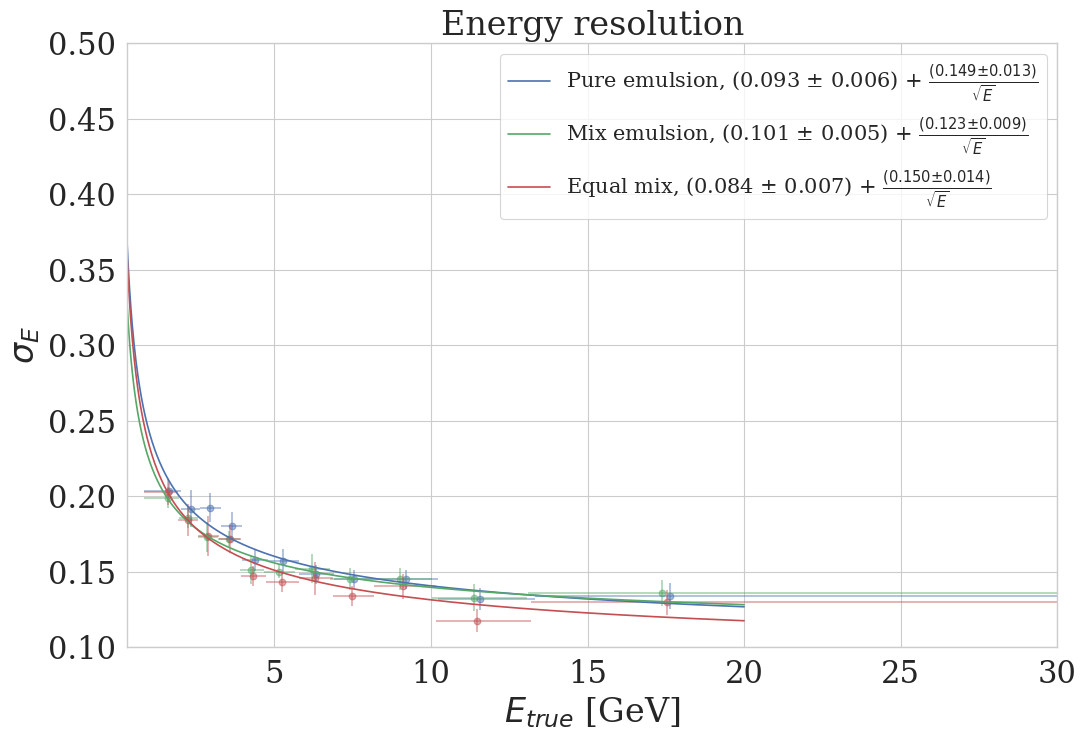

In [14]:
import seaborn as sns
sns.set(context='paper', style="whitegrid", font_scale=2.5, font = 'serif')


fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

plt.grid(True)
axes = plt.gca()
axes.set_xlim([0.3, 30])
axes.set_ylim([0.1, 0.5])

ax.set_xlabel(r'$E_{true}$ [GeV]')
ax.set_ylabel(r'$\sigma_E$')




plot(fit_data_pure_em, label='Pure emulsion', color='b')
plot(fit_data_em_mix, label='Mix emulsion', color='g')
plot(fit_data_eq_mix, label='Equal mix', color='r')

# E_true_Hosenni = np.linspace(2, 17, 10)
# E_Hosenni = 0.28 + 0.09 / np.sqrt(E_true_Hosenni) 
# plt.scatter(E_true_Hosenni, E_Hosenni, c='grey', linewidth=2,label= r'OPERA results, (0.28 ± 0.09) + $\frac{(0.09 ± 0.04)}{\sqrt{E}}$') 

plt.legend(prop={'size': 15})
plt.title("Energy resolution")
plt.savefig("ER_comparison.pdf", bbox_inches='tight')
plt.show()

In [15]:
fit_data_eq_mix['result']